In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import  numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import time
import psutil
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
)
def precision_recall_draw(y_true, y_score):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import precision_recall_curve

    y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])

    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def roc_draw(y_true, y_score):
  from sklearn.preprocessing import label_binarize
  plt.figure(figsize=(15, 10))
  y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])


  for i, class_name in enumerate(class_names):
     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')


  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="best")
  plt.grid(True)
  plt.show()


def evaluate_model(y_true, y_pred, y_pred_proba):
    report_dict = classification_report(y_pred, y_true, target_names=class_names, output_dict=True)
    metrics_df2 = pd.DataFrame(report_dict).transpose()
    print(metrics_df2)
    print("-----------------------------------------------------------------------------------------------------------")

    precision_recall_draw(y_true, y_pred_proba)
    roc_draw(y_true, y_pred_proba)
    cm =confusion_matrix(y_true, y_pred, normalize = 'true')
    #cm_percent_row = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    
    disp = ConfusionMatrixDisplay(cm*100, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)  
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Not normalized Confusion Matrix")
    plt.show()

In [2]:
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torchmetrics
import pytorch_lightning as pl

import data_loader as dl
import experiments as e
from sklearn.model_selection import StratifiedKFold, cross_val_score


!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Abstract_Expressionism','Baroque','Cubism', 'Fauvism', 'Impressionism','Minimalism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cpu'

num_classes = 10


Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
Source files will be saved in "/tmp/tmphv1_dllt".


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

with open('X_densenet_tr2.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_densenet_tr2.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 355), Test: (3701, 355)
Train: (18505, 355), Test: (18505,)


<h2>KNN transition 2</h2>

/opt/conda/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.752277  0.841141  0.794231   491.000000
Baroque                  0.818828  0.768333  0.792777   600.000000
Cubism                   0.756098  0.811905  0.783008   420.000000
Fauvism                  0.698324  0.718391  0.708215   174.000000
Impressionism            0.860640  0.701997  0.773266   651.000000
Minimalism               0.767544  0.966851  0.855746   181.000000
Naive_Art_Primitivism    0.734940  0.851163  0.788793   430.000000
Pointillism              0.754902  0.719626  0.736842   107.000000
Rococo                   0.811475  0.738806  0.773438   402.000000
Ukiyo_e                  0.880342  0.840816  0.860125   245.000000
accuracy                 0.788436  0.788436  0.788436     0.788436
macro avg                0.783537  0.795903  0.786644  3701.000000
weighted avg             0.793740  0.788436  0.787811  3701.000000
--------------------------------------------------------------

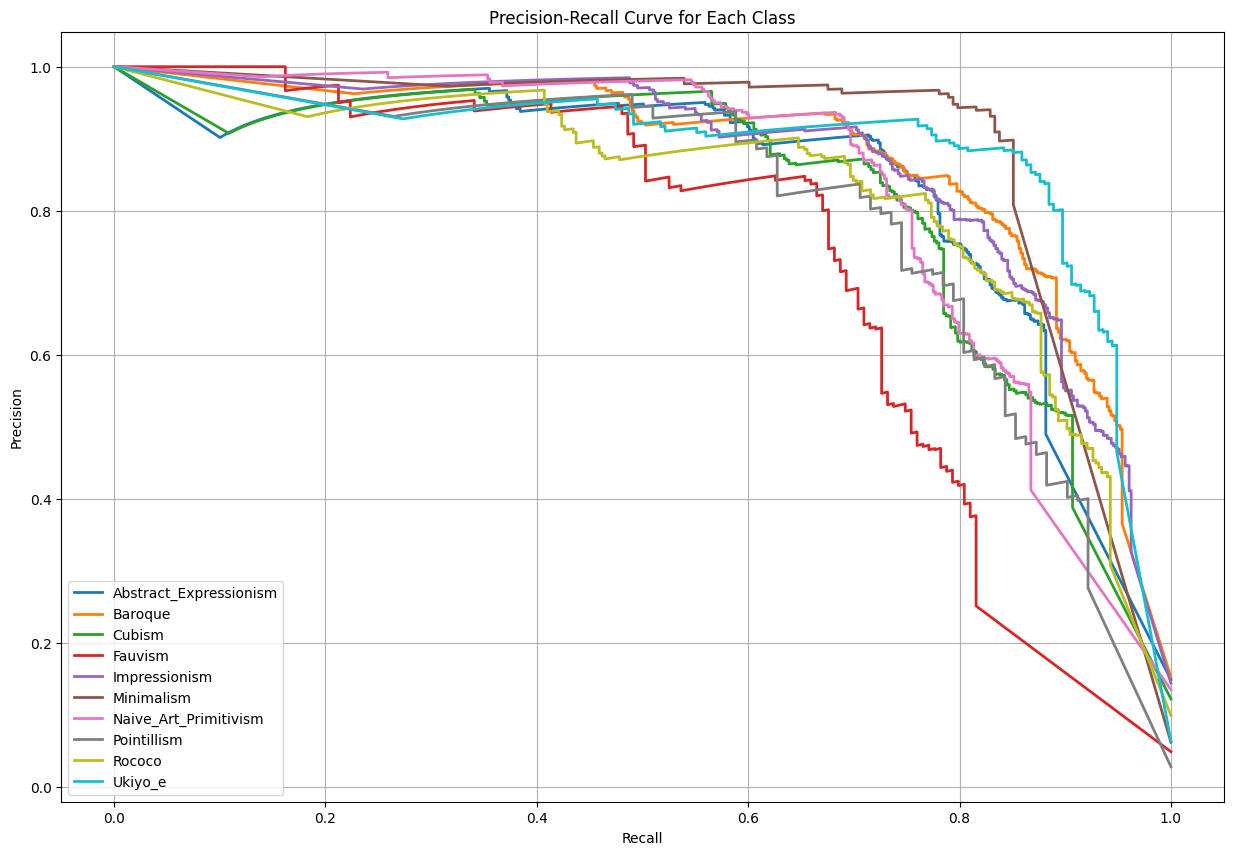

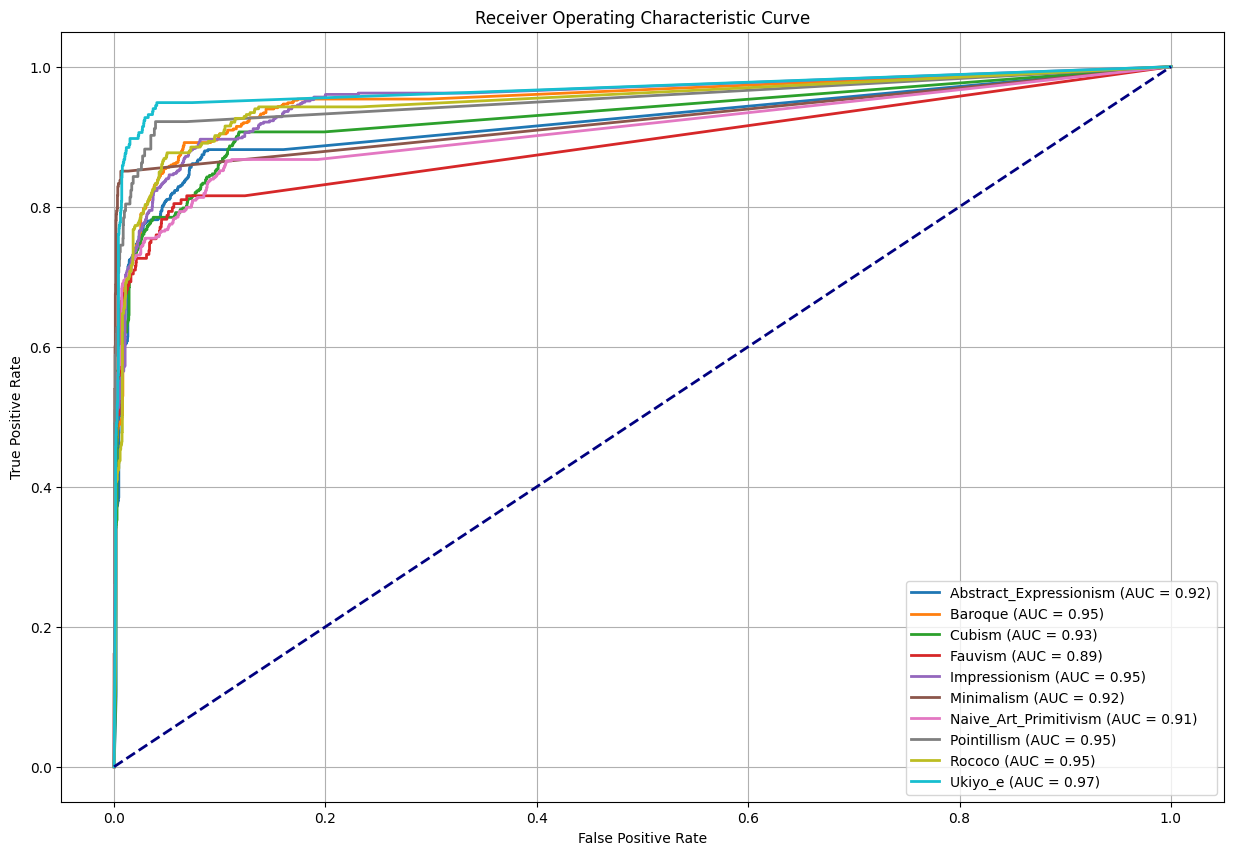

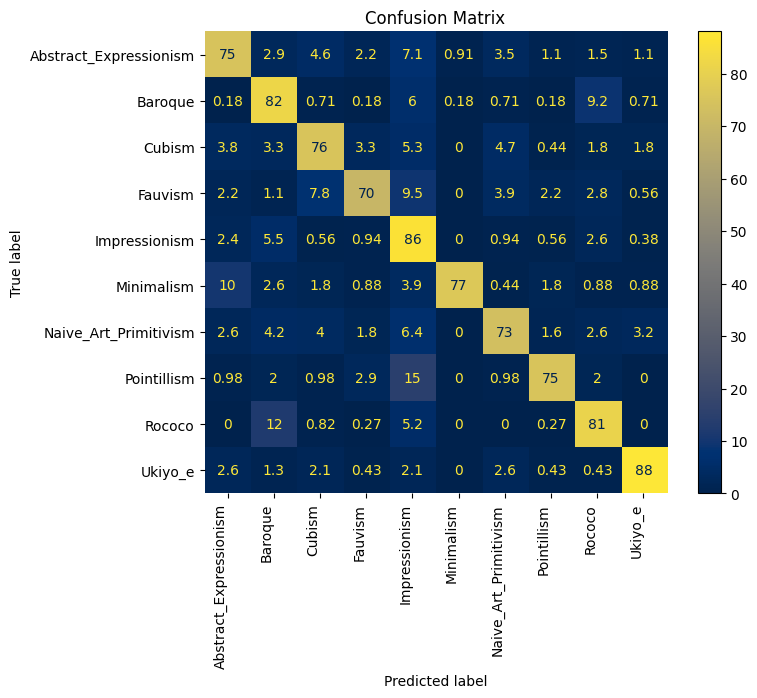

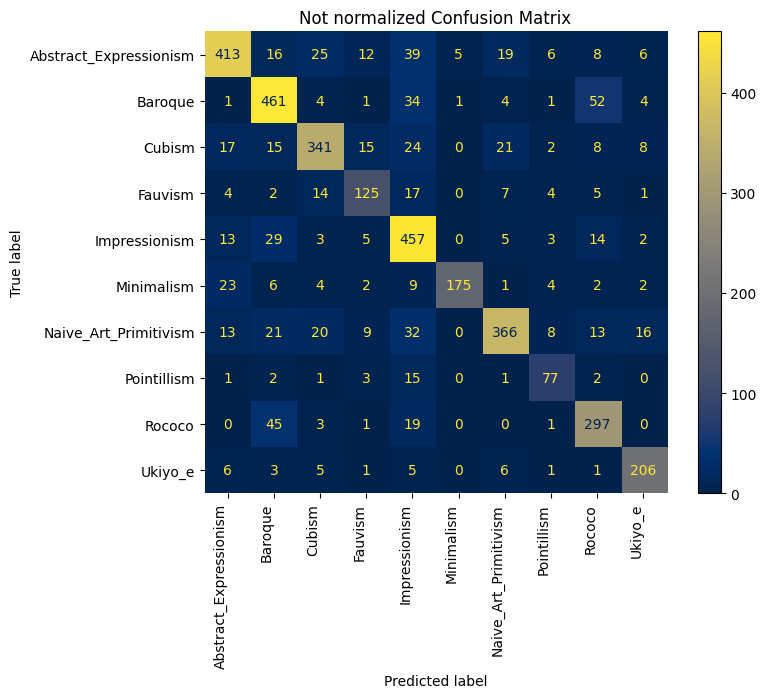

In [5]:
knn_model = KNeighborsClassifier(
    metric='manhattan',
    algorithm='ball_tree',
    n_neighbors=5,
    weights='distance',
    leaf_size=70,
    p=1  
)

knn_model.fit(X_train_scaled, y_train)
frmodel_pred = knn_model.predict(X_test_scaled)
frmodel_pred_proba = knn_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [6]:
knn_model = KNeighborsClassifier(
    metric='manhattan',
    algorithm='ball_tree',
    n_neighbors=5,
    weights='distance',
    leaf_size=70,
    p=1  
)

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  knn_model , 1)
print(avg)
print("....")

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.794287  0.787625  0.787635  0.787625    1.778904   
1         2   0.800209  0.792218  0.792883  0.792218    1.791793   
2         3   0.791932  0.784653  0.784288  0.784653    1.695702   
3         4   0.811129  0.804918  0.804802  0.804918    1.607668   
4         5   0.798159  0.792759  0.793062  0.792759    1.779370   
5   Average   0.799143  0.792434  0.792534  0.792434    1.730688   
6  1.581139   0.007439  0.007741  0.007793  0.007741    0.078719   

   Prediction time  
0        94.308341  
1        94.390801  
2        94.509357  
3        90.186228  
4        93.508821  
5        93.380709  
6         1.828644  
....


<h2>MLP transition 2</h2>

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.775956  0.756661  0.766187   563.000000
Baroque                  0.737123  0.753176  0.745063   551.000000
Cubism                   0.729490  0.749431  0.739326   439.000000
Fauvism                  0.519553  0.620000  0.565350   150.000000
Impressionism            0.843691  0.759322  0.799286   590.000000
Minimalism               0.785088  0.852381  0.817352   210.000000
Naive_Art_Primitivism    0.680723  0.710692  0.695385   477.000000
Pointillism              0.666667  0.701031  0.683417    97.000000
Rococo                   0.699454  0.699454  0.699454   366.000000
Ukiyo_e                  0.850427  0.771318  0.808943   258.000000
accuracy                 0.743583  0.743583  0.743583     0.743583
macro avg                0.728817  0.737346  0.731976  3701.000000
weighted avg             0.748075  0.743583  0.744982  3701.000000
--------------------------------------------------------------

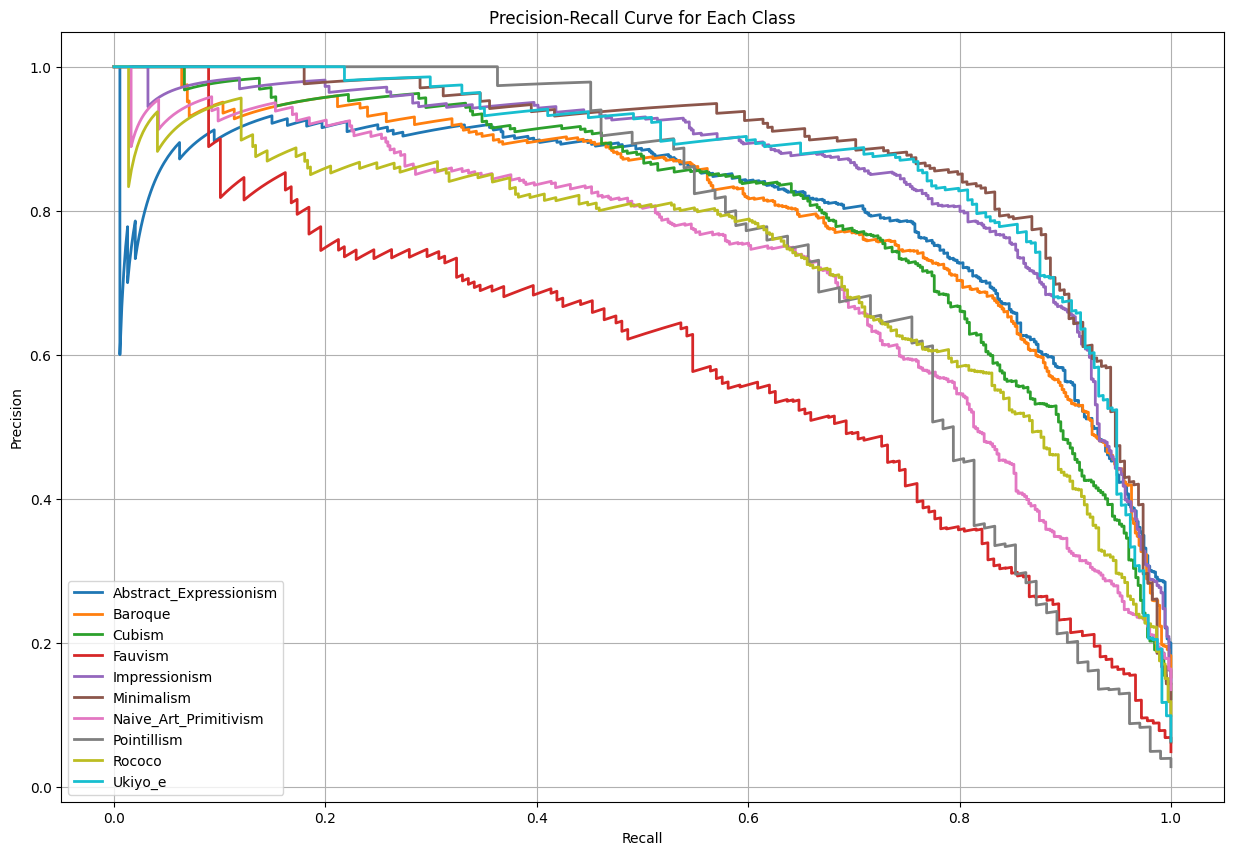

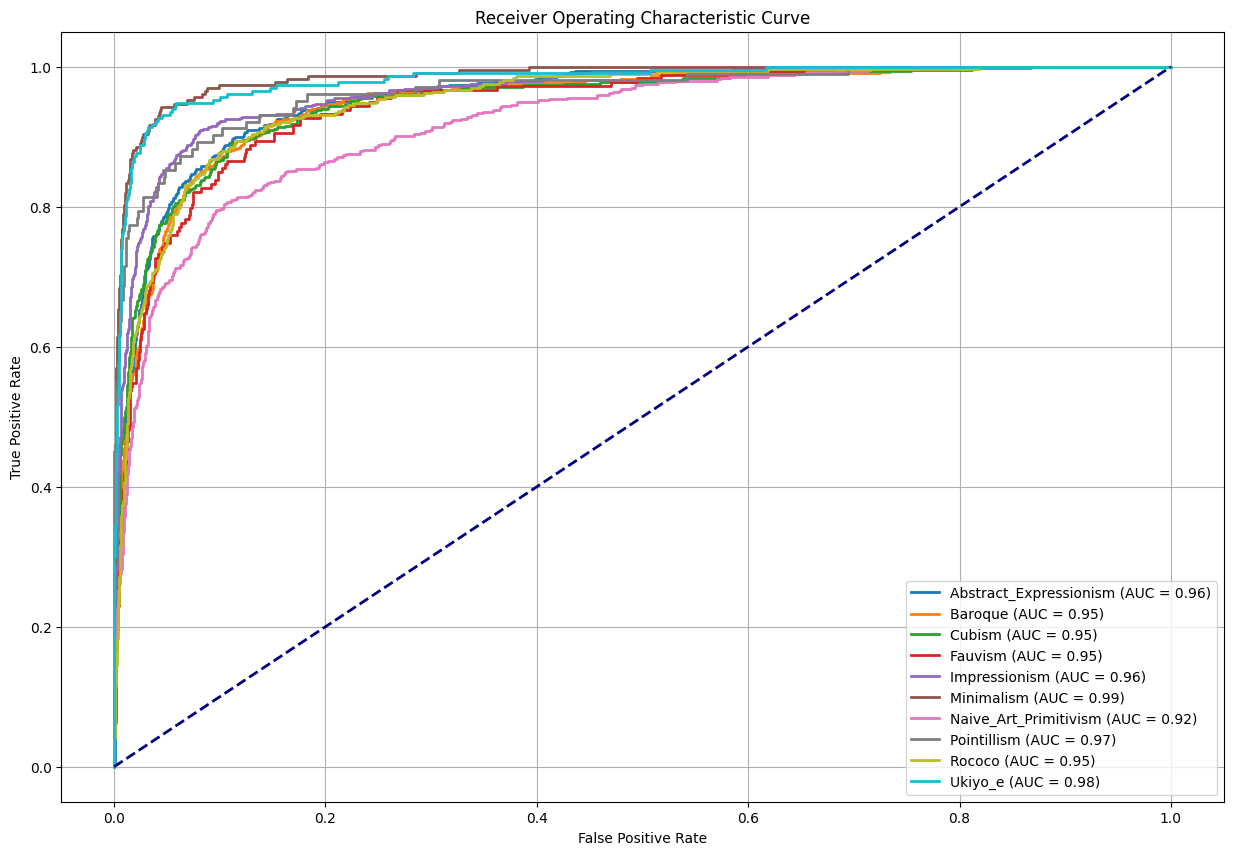

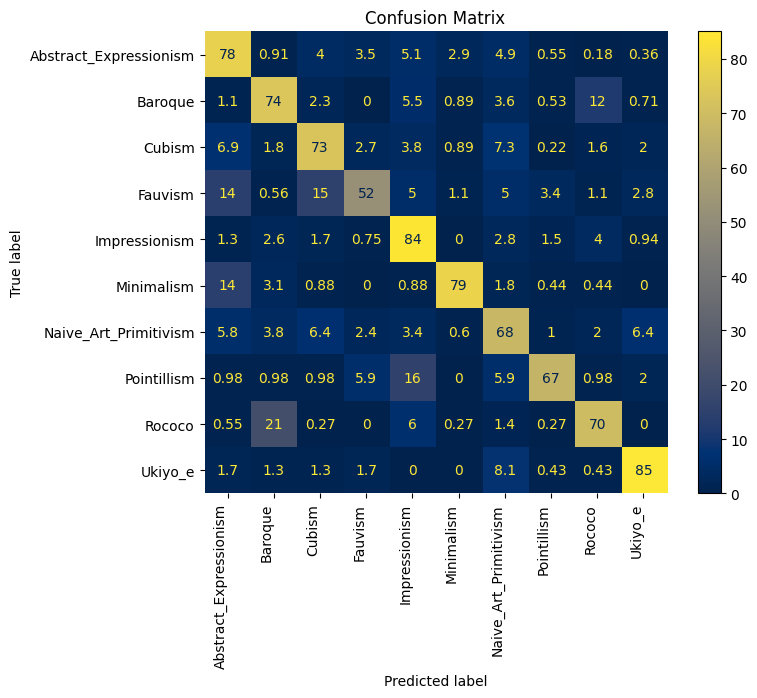

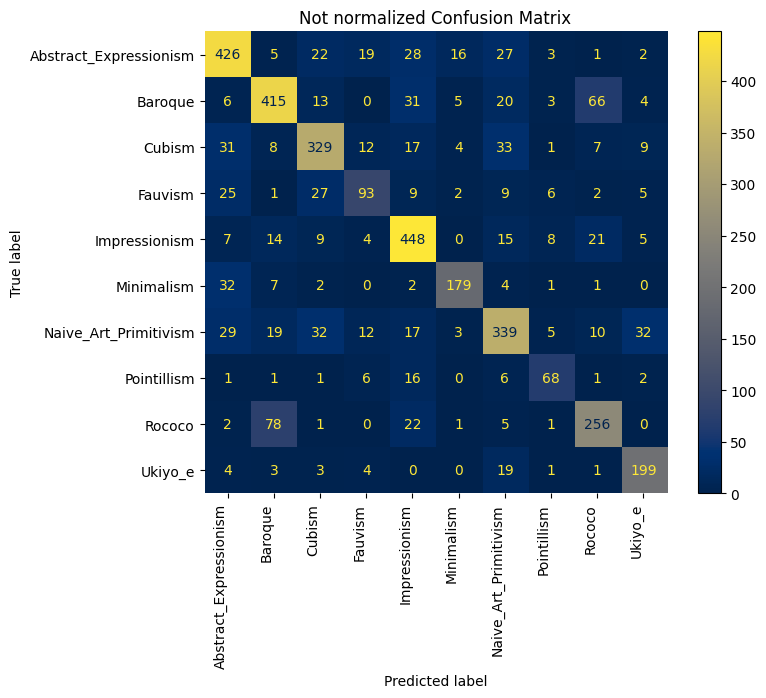

In [7]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
        hidden_layer_sizes=(470, 170, 90),
        activation='tanh',
        solver='adam',
        alpha=4.0483726870044784e-05,
        batch_size=32,
        learning_rate_init=0.0008849446388565386,
        max_iter=899,
        random_state=42
    )
mlp.fit(X_train_scaled, y_train)
frmodel_pred = mlp.predict(X_test_scaled)
frmodel_pred_proba = mlp.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [8]:
mlp = MLPClassifier(
        hidden_layer_sizes=(470, 170, 90),
        activation='tanh',
        solver='adam',
        alpha=4.0483726870044784e-05,
        batch_size=32,
        learning_rate_init=0.0008849446388565386,
        max_iter=899,
        random_state=42
    )
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  mlp , 1)
print(avg)

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


       Fold  Precision    Recall        F1  Accuracy   Train time  \
0         1   0.813197  0.813294  0.812784  0.813294  1249.482641   
1         2   0.790711  0.789787  0.789422  0.789787  1132.618989   
2         3   0.821841  0.821400  0.821174  0.821400  1172.807365   
3         4   0.760954  0.758714  0.758857  0.758714  1878.598418   
4         5   0.831403  0.831397  0.831182  0.831397   504.493526   
5   Average   0.803621  0.802918  0.802684  0.802918  1187.600188   
6  1.581139   0.028208  0.029098  0.028951  0.029098   487.643431   

   Prediction time  
0         0.316524  
1         0.481811  
2         0.481706  
3         0.394716  
4         0.316500  
5         0.398251  
6         0.082647  


<h2>Xgboost tr 2</h2>

                        precision    recall  f1-score     support
Abstract_Expressionism   0.874317  0.833333  0.853333   576.00000
Baroque                  0.882771  0.836700  0.859118   594.00000
Cubism                   0.840355  0.879350  0.859410   431.00000
Fauvism                  0.731844  0.834395  0.779762   157.00000
Impressionism            0.892655  0.818653  0.854054   579.00000
Minimalism               0.868421  0.925234  0.895928   214.00000
Naive_Art_Primitivism    0.807229  0.834025  0.820408   482.00000
Pointillism              0.833333  0.955056  0.890052    89.00000
Rococo                   0.767760  0.836310  0.800570   336.00000
Ukiyo_e                  0.918803  0.884774  0.901468   243.00000
accuracy                 0.848960  0.848960  0.848960     0.84896
macro avg                0.841749  0.863783  0.851410  3701.00000
weighted avg             0.851727  0.848960  0.849389  3701.00000
----------------------------------------------------------------------------

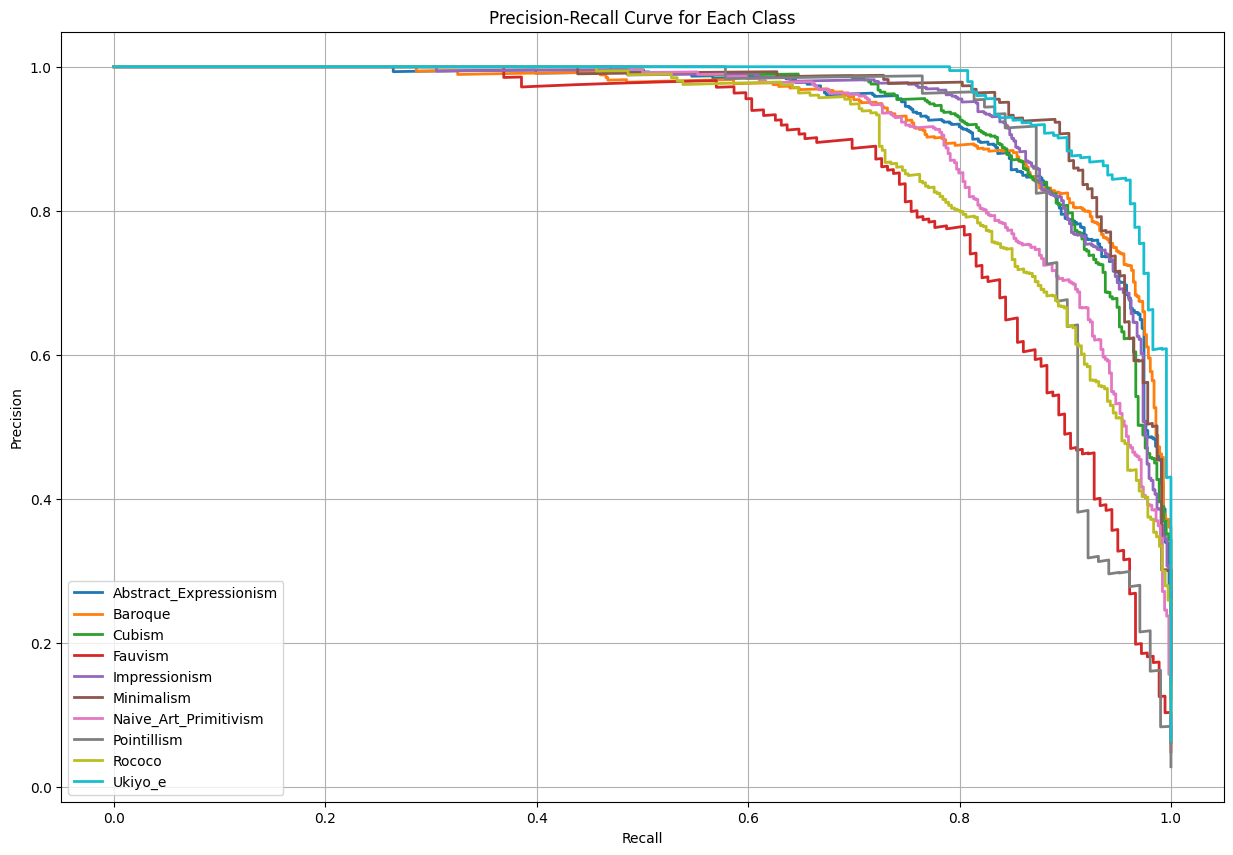

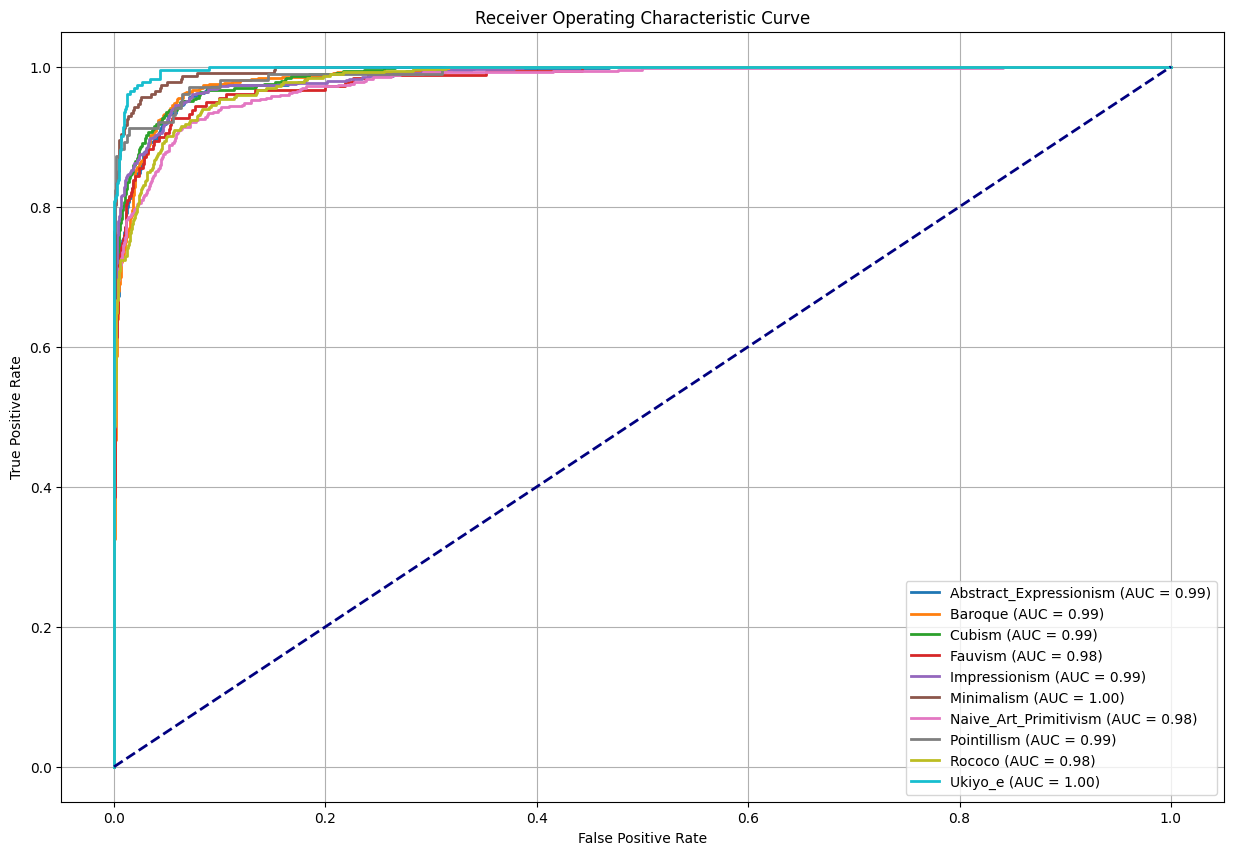

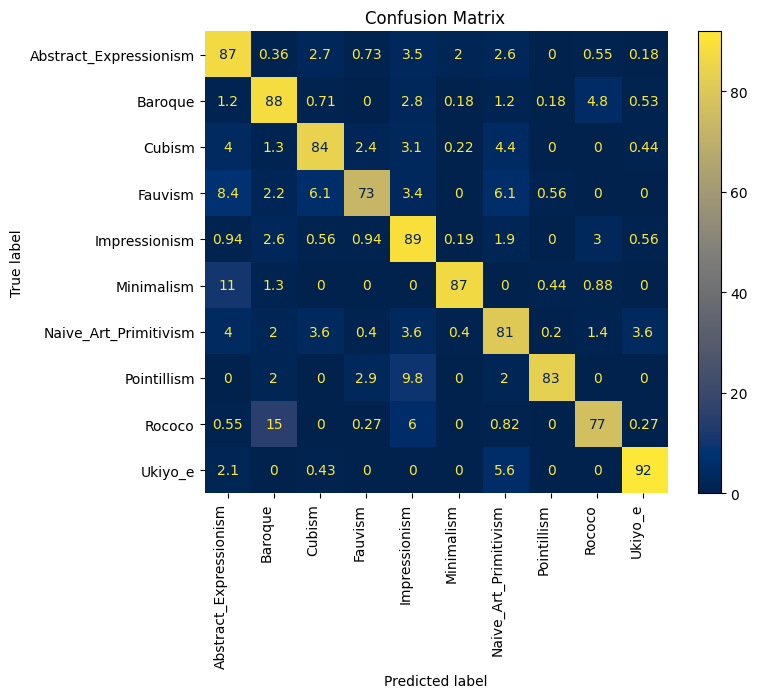

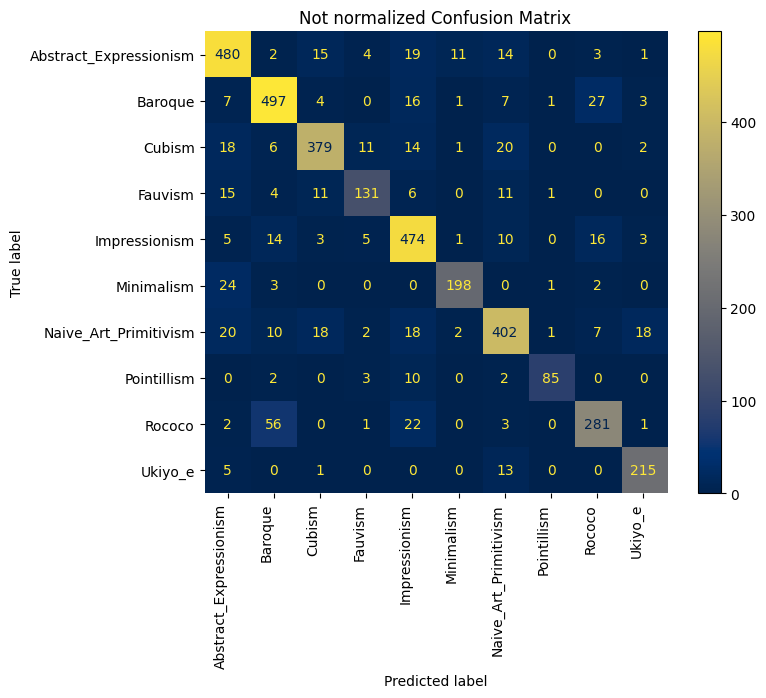

In [4]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=900,
    max_depth=7,
    learning_rate=0.017858303358259497,
    subsample=0.5409381875421144,
    colsample_bytree=0.8412599835848872,
    gamma=0.22384600453471776,
    reg_lambda=1.8718151397420606,
    reg_alpha=0.018566947493126998,
    objective="multi:softmax",  
    eval_metric="mlogloss",
    tree_method="hist", 
)
xgb_model.fit(X_train_scaled, y_train)
frmodel_pred = xgb_model.predict(X_test_scaled)
frmodel_pred_proba = xgb_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [6]:
xgb_model = xgb.XGBClassifier(
    n_estimators=900,
    max_depth=7,
    learning_rate=0.017858303358259497,
    subsample=0.5409381875421144,
    colsample_bytree=0.8412599835848872,
    gamma=0.22384600453471776,
    reg_lambda=1.8718151397420606,
    reg_alpha=0.018566947493126998,
    objective="multi:softmax",  
    eval_metric="mlogloss",
    tree_method="hist", 
)

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  xgb_model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.838976  0.837341  0.836812  0.837341  171.697478   
1         2   0.846622  0.845717  0.845609  0.845717  171.295901   
2         3   0.847936  0.846258  0.845976  0.846258  172.059141   
3         4   0.865791  0.865172  0.864651  0.865172  171.378859   
4         5   0.855896  0.855444  0.855019  0.855444  170.777904   
5   Average   0.851044  0.849986  0.849613  0.849986  171.441857   
6  1.581139   0.010196  0.010635  0.010589  0.010635    0.477621   

   Prediction time  
0         0.024012  
1         0.024558  
2         0.024642  
3         0.023800  
4         0.024528  
5         0.024308  
6         0.000377  


<h2>rf tr 2</h2>

/venv/main/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.846995  0.804498  0.825200   578.000000
Baroque                  0.868561  0.817726  0.842377   598.000000
Cubism                   0.838137  0.851351  0.844693   444.000000
Fauvism                  0.664804  0.881481  0.757962   135.000000
Impressionism            0.883239  0.760130  0.817073   617.000000
Minimalism               0.859649  0.924528  0.890909   212.000000
Naive_Art_Primitivism    0.783133  0.845987  0.813347   461.000000
Pointillism              0.764706  0.886364  0.821053    88.000000
Rococo                   0.767760  0.861963  0.812139   326.000000
Ukiyo_e                  0.901709  0.871901  0.886555   242.000000
accuracy                 0.831127  0.831127  0.831127     0.831127
macro avg                0.817869  0.850593  0.831131  3701.000000
weighted avg             0.836225  0.831127  0.831557  3701.000000
--------------------------------------------------------------

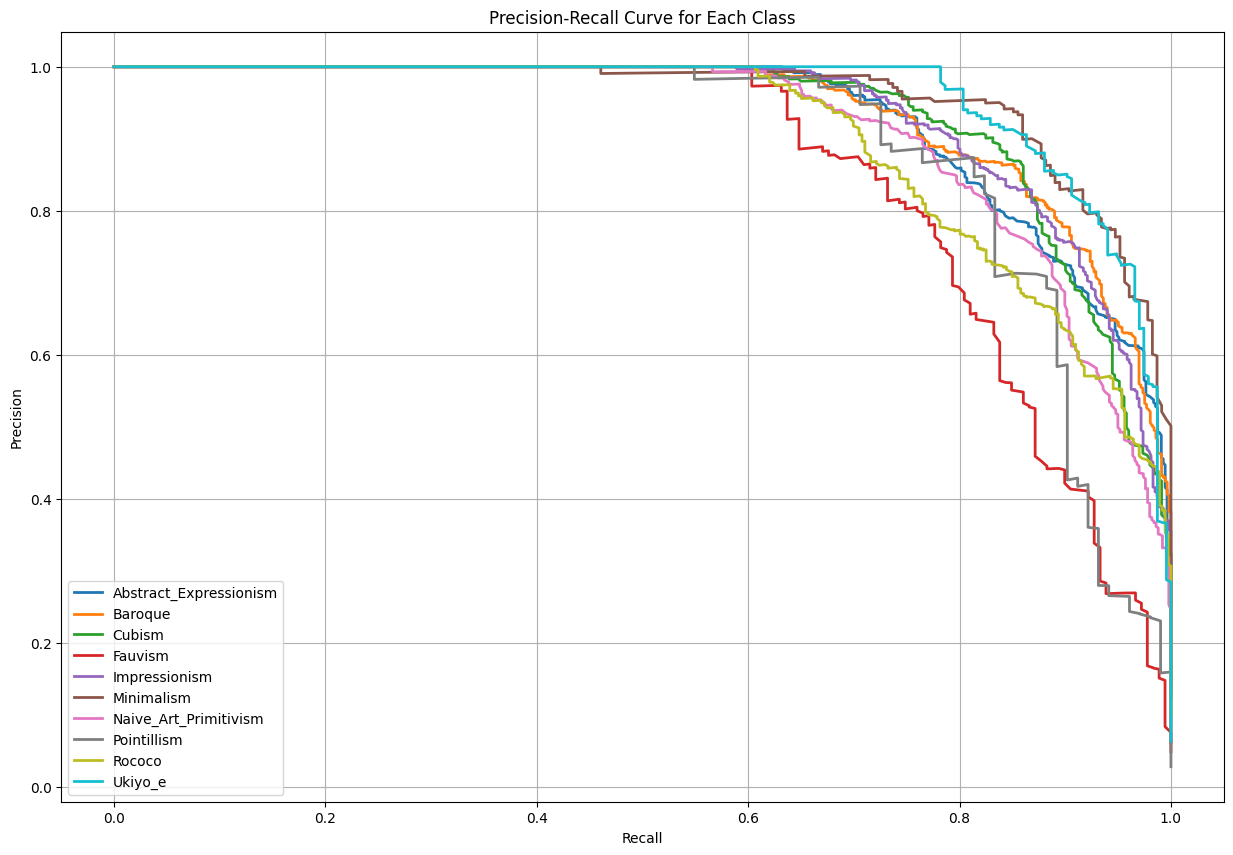

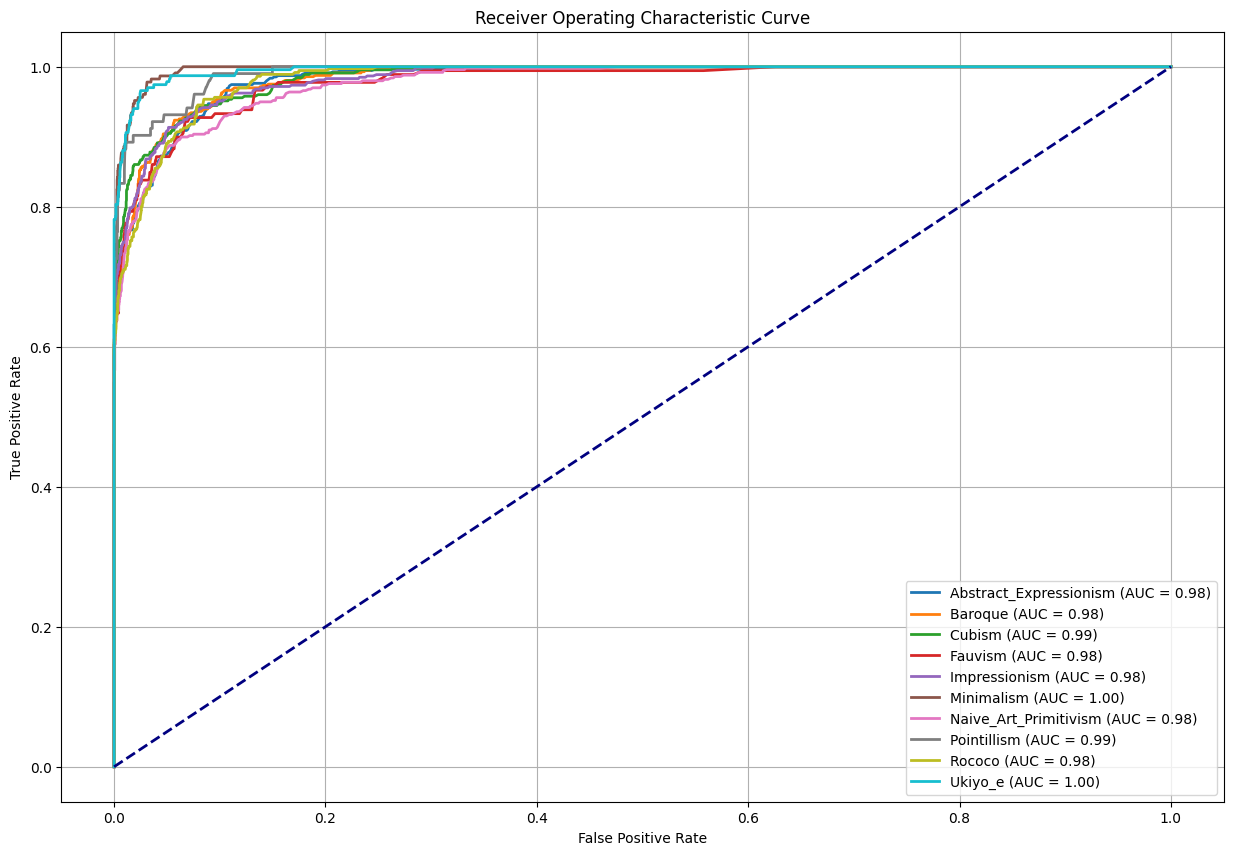

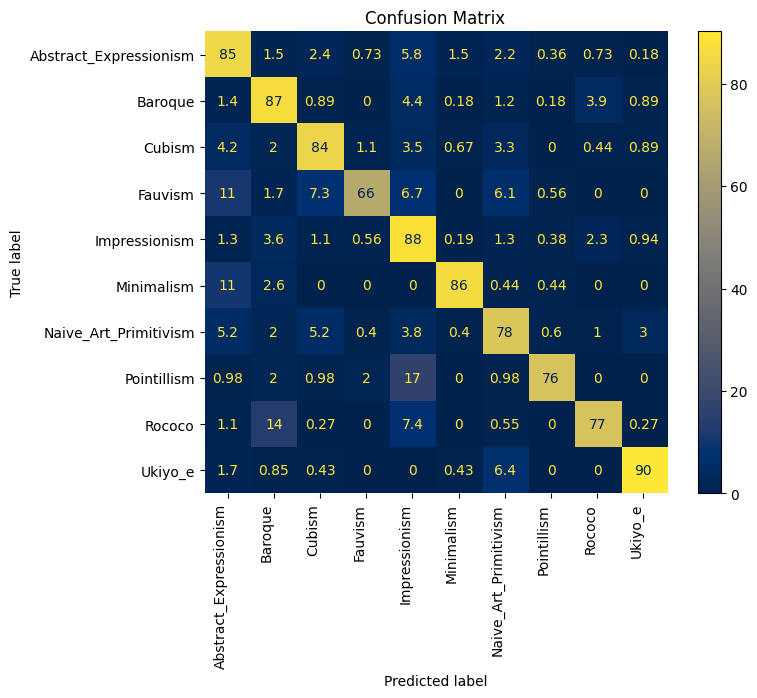

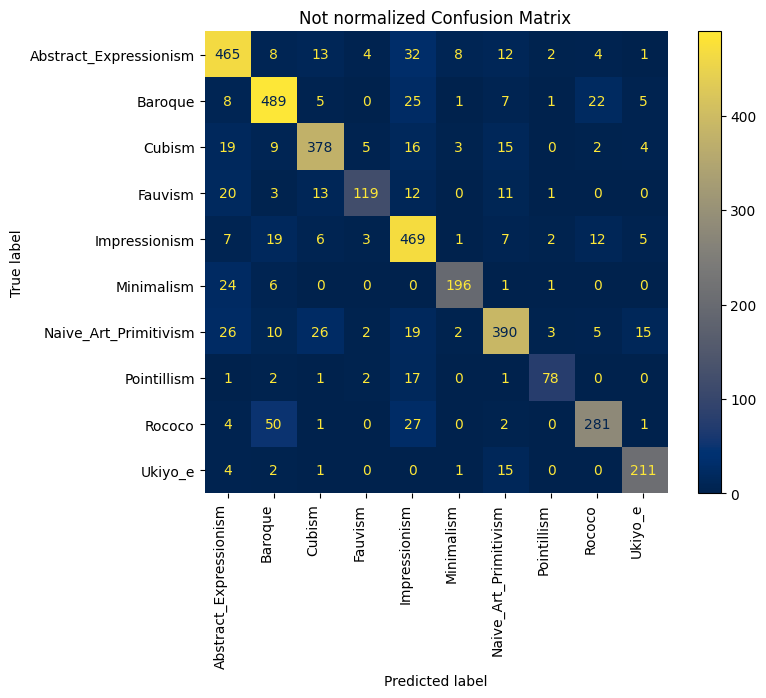

In [7]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators = 1000, 
                                 max_depth = 48, 
                                 min_samples_split =  2,
                                 min_samples_leaf = 1, 
                                 max_features = 'sqrt', 
                                 bootstrap = False,  
                                 criterion = 'gini')
rfmodel.fit(X_train_scaled, y_train)
frmodel_pred = rfmodel.predict(X_test_scaled)
frmodel_pred_proba = rfmodel.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [8]:
rfmodel = RandomForestClassifier(n_estimators = 1000, 
                                 max_depth = 48, 
                                 min_samples_split =  2,
                                 min_samples_leaf = 1, 
                                 max_features = 'sqrt', 
                                 bootstrap = False,  
                                 criterion = 'gini')

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  rfmodel , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.831169  0.827074  0.826066  0.827074  351.257246   
1         2   0.834589  0.831127  0.830701  0.831127  349.111124   
2         3   0.832438  0.828425  0.827815  0.828425  349.718124   
3         4   0.843484  0.840313  0.839694  0.840313  350.904454   
4         5   0.838349  0.836531  0.836021  0.836531  350.190344   
5   Average   0.836006  0.832694  0.832059  0.832694  350.236258   
6  1.581139   0.004989  0.005591  0.005696  0.005591    0.869684   

   Prediction time  
0         0.724402  
1         0.727555  
2         0.736416  
3         0.737943  
4         0.737632  
5         0.732790  
6         0.006343  


<h1>Transition 1</h1>

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

with open('X_densenet_tr1.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_densenet_tr1.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 227), Test: (3701, 227)
Train: (18505, 227), Test: (18505,)


<h2>Xgboost tr 1</h2>

                        precision    recall  f1-score      support
Abstract_Expressionism   0.810764  0.820738  0.815721   569.000000
Baroque                  0.840351  0.855357  0.847788   560.000000
Cubism                   0.825581  0.810502  0.817972   438.000000
Fauvism                  0.728395  0.781457  0.753994   151.000000
Impressionism            0.908638  0.848062  0.877306   645.000000
Minimalism               0.830409  0.893082  0.860606   159.000000
Naive_Art_Primitivism    0.820565  0.784200  0.801970   519.000000
Pointillism              0.738095  0.898551  0.810458    69.000000
Rococo                   0.786260  0.828418  0.806789   373.000000
Ukiyo_e                  0.935484  0.931193  0.933333   218.000000
accuracy                 0.834639  0.834639  0.834639     0.834639
macro avg                0.822454  0.845156  0.832594  3701.000000
weighted avg             0.836431  0.834639  0.834983  3701.000000
--------------------------------------------------------------

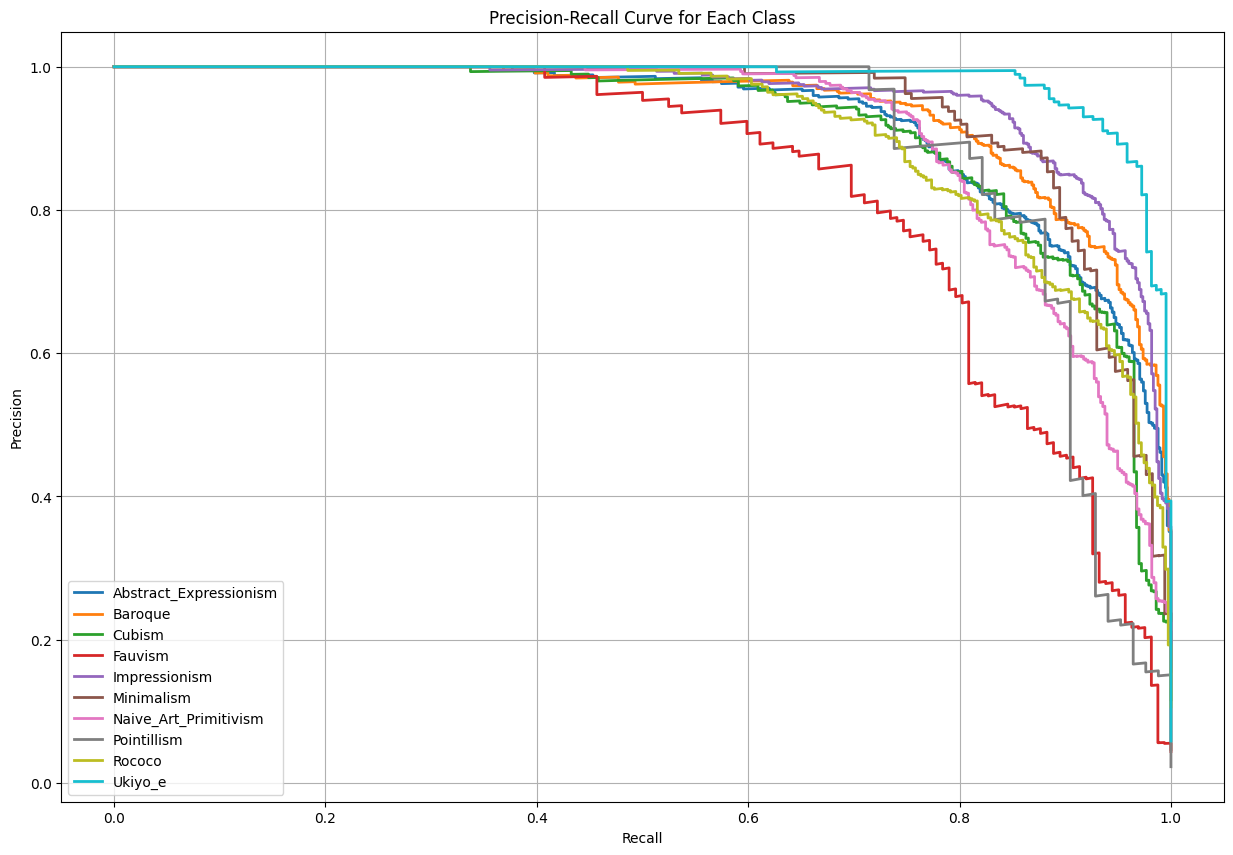

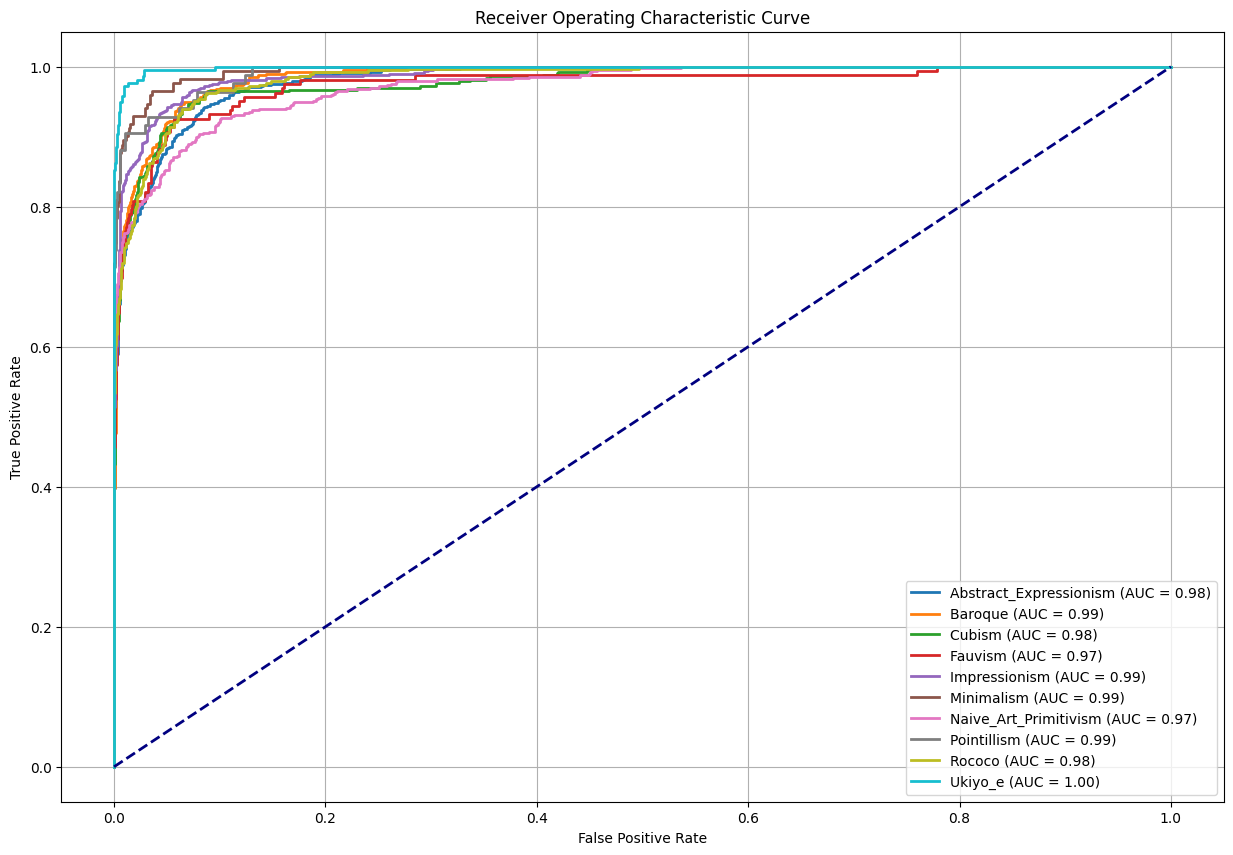

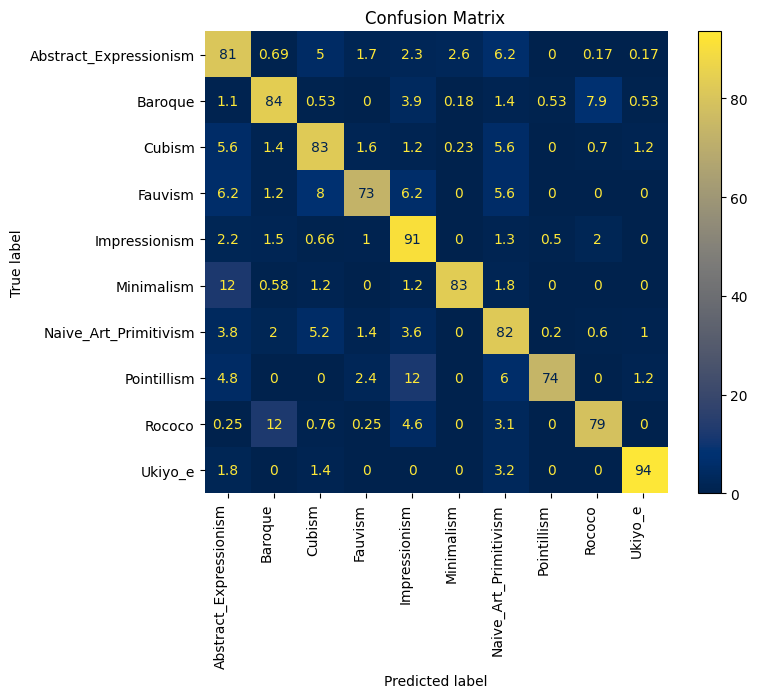

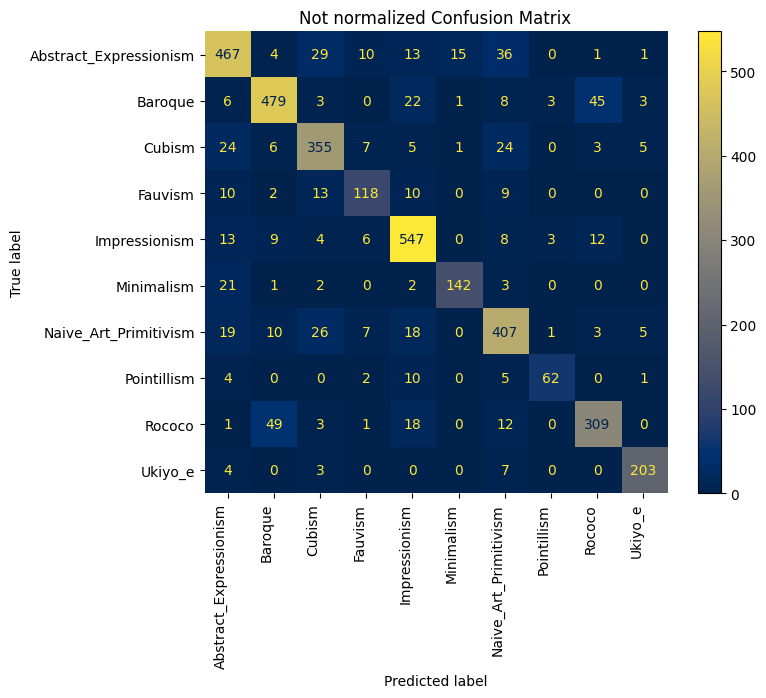

In [10]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=900,
    max_depth=7,
    learning_rate= 0.02151183593443282,
    subsample= 0.9127140355289002,
    colsample_bytree=0.8348880938007835,
    gamma=0.22384600453471776,
    reg_lambda=0.05492887311781053,
    reg_alpha= 0.013671070531042214,
    objective="multi:softmax",  
    eval_metric="mlogloss",
    tree_method="hist", 
)
xgb_model.fit(X_train_scaled, y_train)
frmodel_pred = xgb_model.predict(X_test_scaled)
frmodel_pred_proba = xgb_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [11]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=900,
    max_depth=7,
    learning_rate= 0.02151183593443282,
    subsample= 0.9127140355289002,
    colsample_bytree=0.8348880938007835,
    gamma=0.22384600453471776,
    reg_lambda=0.05492887311781053,
    reg_alpha= 0.013671070531042214,
    objective="multi:softmax",  
    eval_metric="mlogloss",
    tree_method="hist", 
)
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  xgb_model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.839870  0.839503  0.838984  0.839503   95.606237   
1         2   0.845508  0.844637  0.844228  0.844637   95.593243   
2         3   0.856116  0.855444  0.855094  0.855444   96.309420   
3         4   0.843848  0.842475  0.842377  0.842475   96.839010   
4         5   0.845532  0.844366  0.843733  0.844366   96.339976   
5   Average   0.846175  0.845285  0.844883  0.845285   96.137577   
6  1.581139   0.006018  0.006038  0.006064  0.006038    0.534117   

   Prediction time  
0         0.020695  
1         0.020146  
2         0.020429  
3         0.020498  
4         0.020126  
5         0.020379  
6         0.000243  


<h2>RF tr 1</h2>

/venv/main/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.812500  0.828319  0.820333   565.000000
Baroque                  0.840351  0.830156  0.835222   577.000000
Cubism                   0.795349  0.799065  0.797203   428.000000
Fauvism                  0.666667  0.857143  0.750000   126.000000
Impressionism            0.918605  0.796830  0.853395   694.000000
Minimalism               0.842105  0.900000  0.870091   160.000000
Naive_Art_Primitivism    0.794355  0.805726  0.800000   489.000000
Pointillism              0.773810  0.866667  0.817610    75.000000
Rococo                   0.765903  0.847887  0.804813   355.000000
Ukiyo_e                  0.944700  0.883621  0.913140   232.000000
accuracy                 0.826533  0.826533  0.826533     0.826533
macro avg                0.815434  0.841541  0.826181  3701.000000
weighted avg             0.831706  0.826533  0.827523  3701.000000
--------------------------------------------------------------

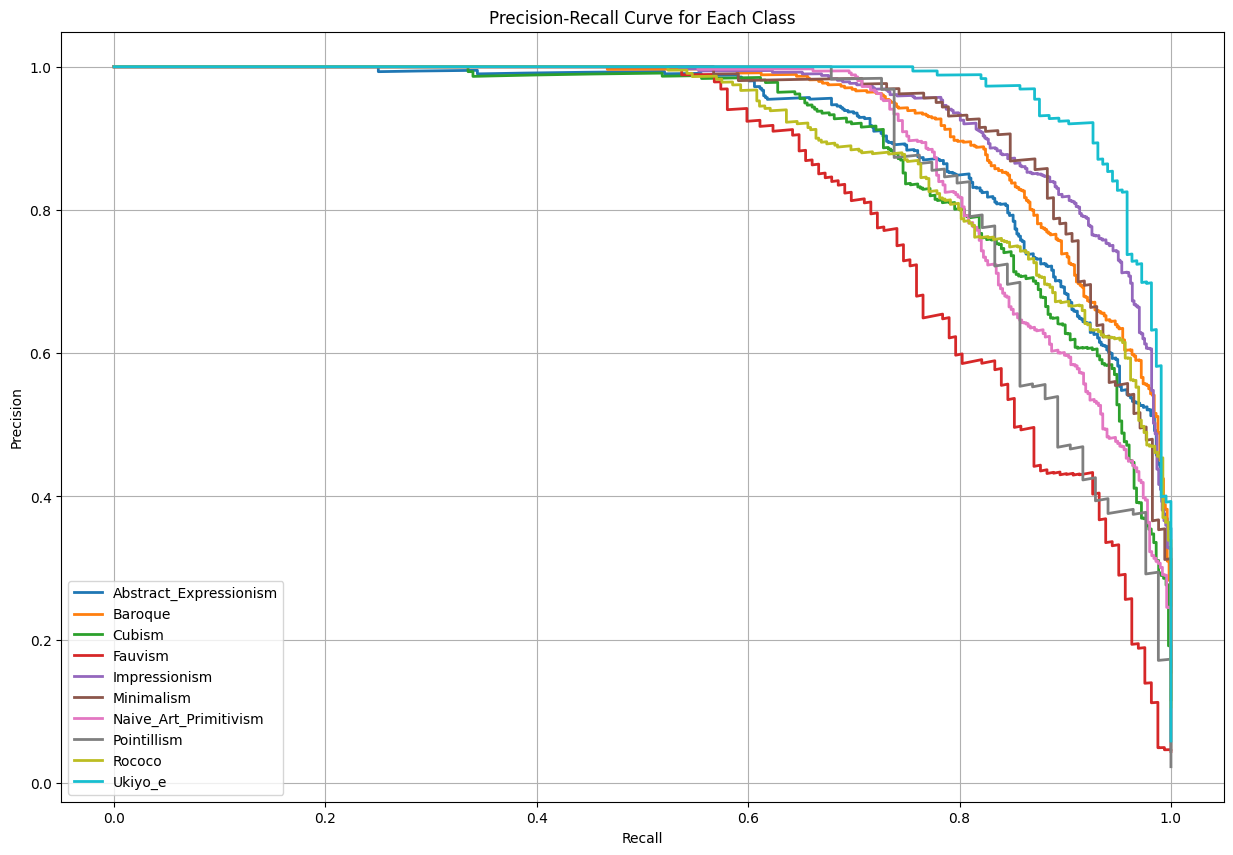

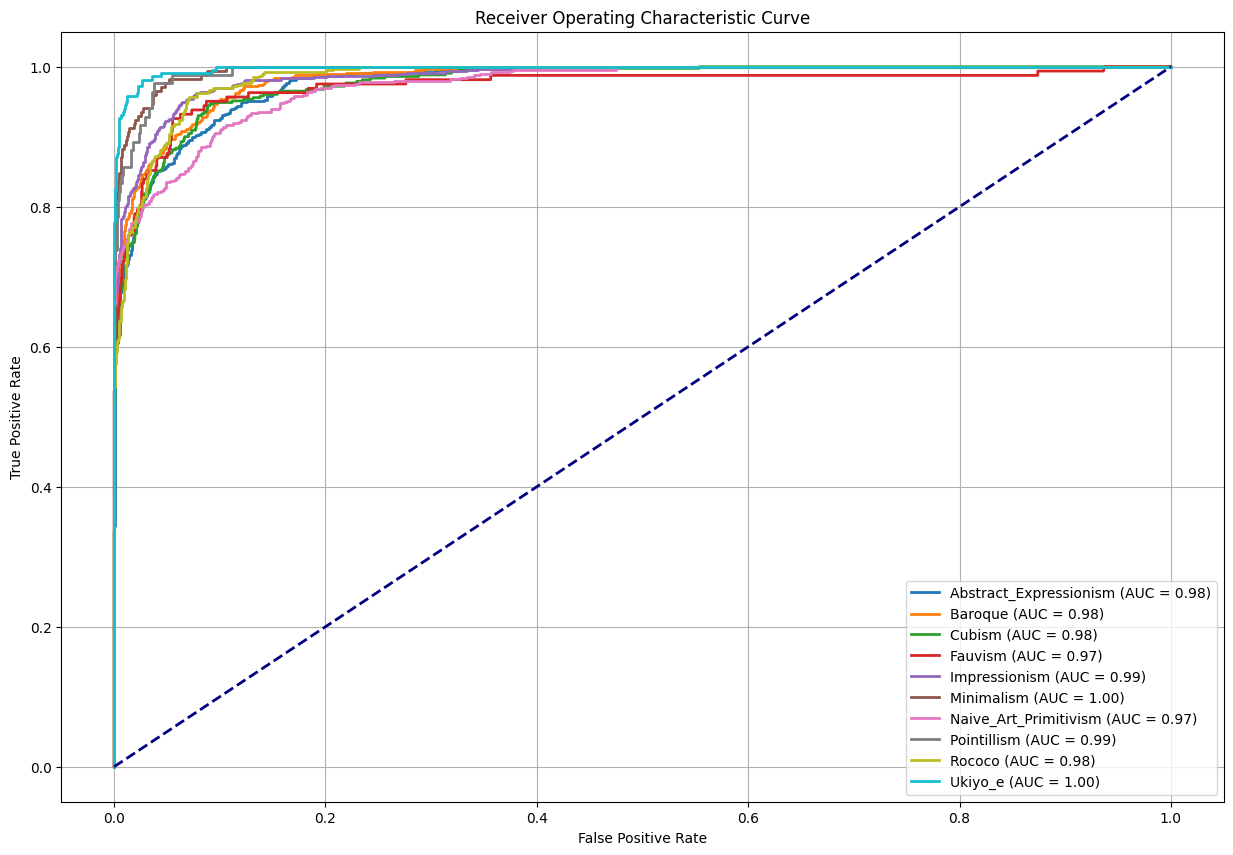

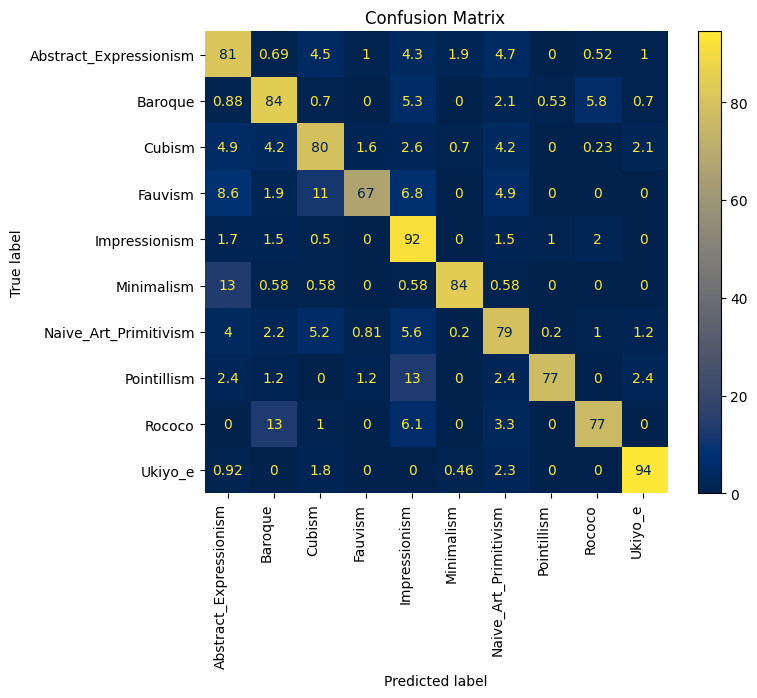

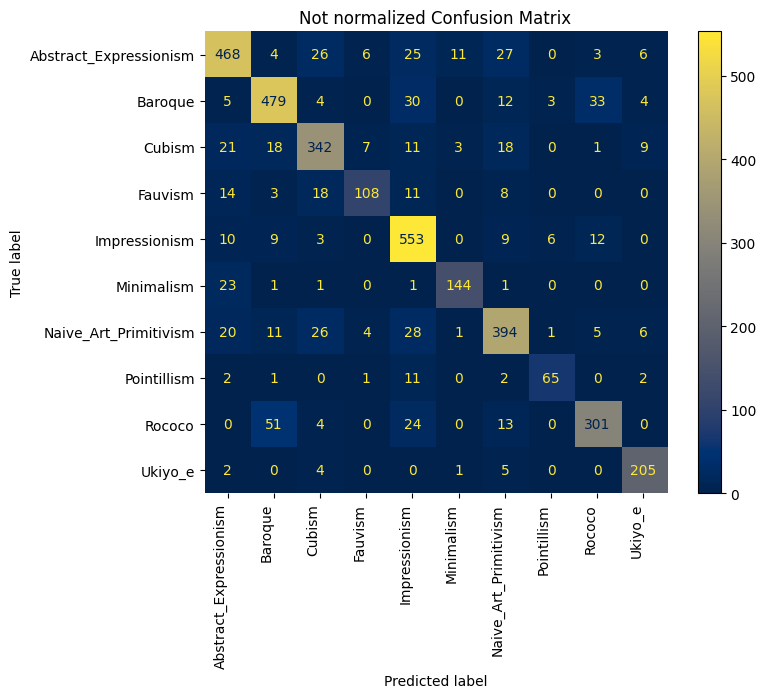

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators = 600, 
                                 max_depth = 41, 
                                 min_samples_split = 9,
                                 min_samples_leaf = 1, 
                                 max_features = 'sqrt', 
                                 bootstrap = False,  
                                 criterion = 'entropy')
rfmodel.fit(X_train_scaled, y_train)
frmodel_pred = rfmodel.predict(X_test_scaled)
frmodel_pred_proba = rfmodel.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [13]:
rfmodel = RandomForestClassifier(n_estimators = 600, 
                                 max_depth = 41, 
                                 min_samples_split = 9,
                                 min_samples_leaf = 1, 
                                 max_features = 'sqrt', 
                                 bootstrap = False,  
                                 criterion = 'entropy')

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  rfmodel , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.829196  0.828155  0.826966  0.828155  285.112048   
1         2   0.828762  0.826804  0.825922  0.826804  286.202225   
2         3   0.839998  0.838152  0.837256  0.838152  287.101347   
3         4   0.829363  0.827074  0.826326  0.827074  287.012926   
4         5   0.839279  0.837341  0.836518  0.837341  287.123636   
5   Average   0.833320  0.831505  0.830598  0.831505  286.510437   
6  1.581139   0.005778  0.005727  0.005759  0.005727    0.870082   

   Prediction time  
0         0.355476  
1         0.353527  
2         0.357960  
3         0.359547  
4         0.359515  
5         0.357205  
6         0.002642  


<h2>Transiton3</h2>

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

with open('X_densenet_tr3 (2).pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_densenet_tr3.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 611), Test: (3701, 611)
Train: (18505, 611), Test: (18505,)


/venv/main/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.839655  0.799672  0.819176   609.000000
Baroque                  0.867890  0.811321  0.838652   583.000000
Cubism                   0.791569  0.810552  0.800948   417.000000
Fauvism                  0.766667  0.763033  0.764846   211.000000
Impressionism            0.839506  0.833625  0.836555   571.000000
Minimalism               0.851648  0.861111  0.856354   180.000000
Naive_Art_Primitivism    0.760417  0.765199  0.762800   477.000000
Pointillism              0.735849  0.795918  0.764706    98.000000
Rococo                   0.792746  0.894737  0.840659   342.000000
Ukiyo_e                  0.848624  0.868545  0.858469   213.000000
accuracy                 0.817076  0.817076  0.817076     0.817076
macro avg                0.809457  0.820371  0.814317  3701.000000
weighted avg             0.818304  0.817076  0.817121  3701.000000
--------------------------------------------------------------

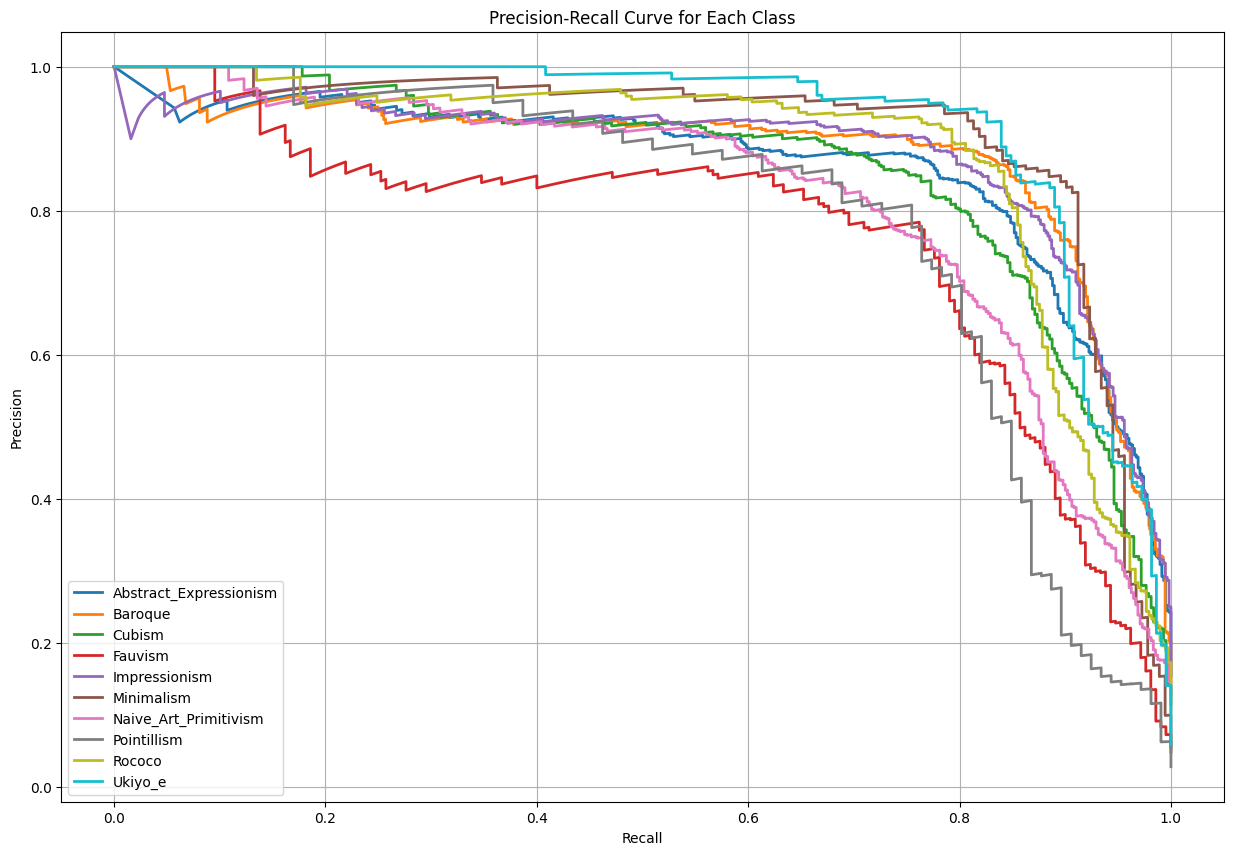

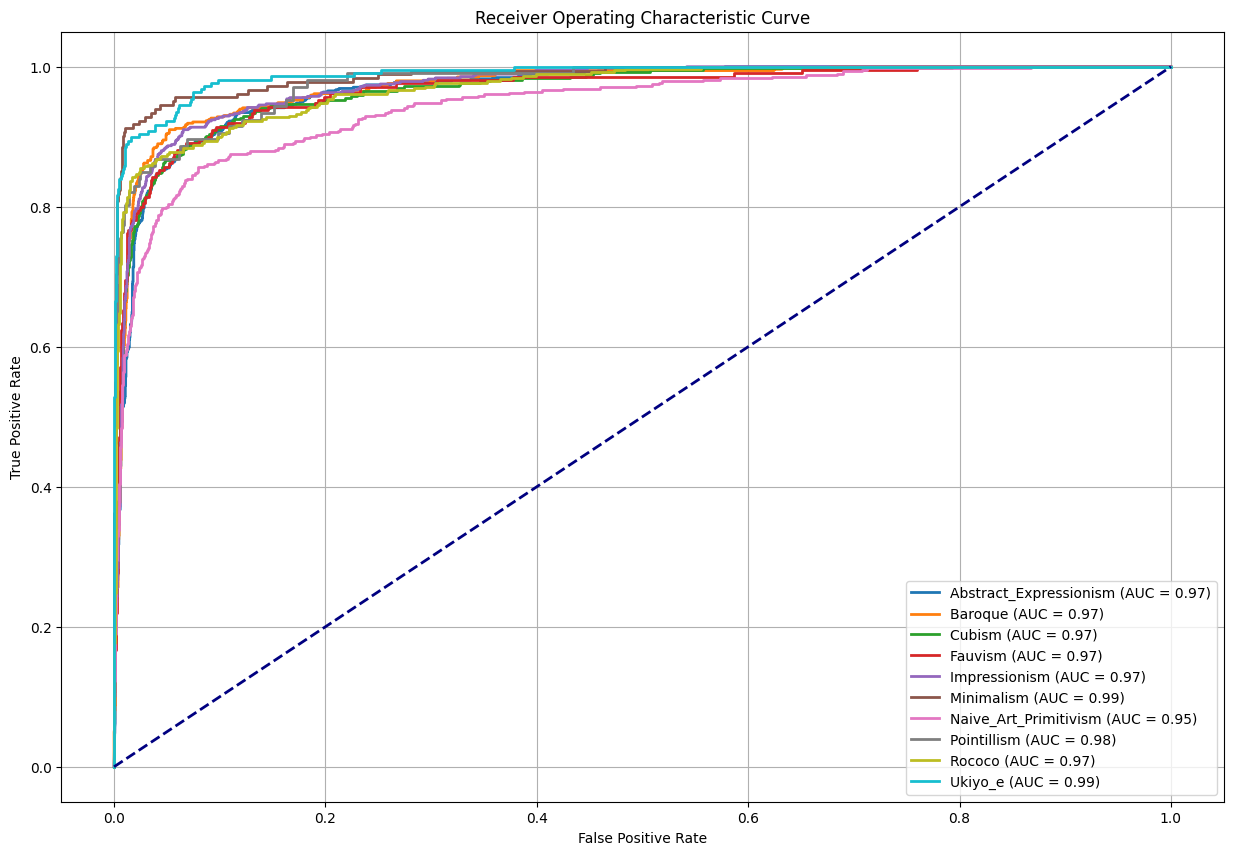

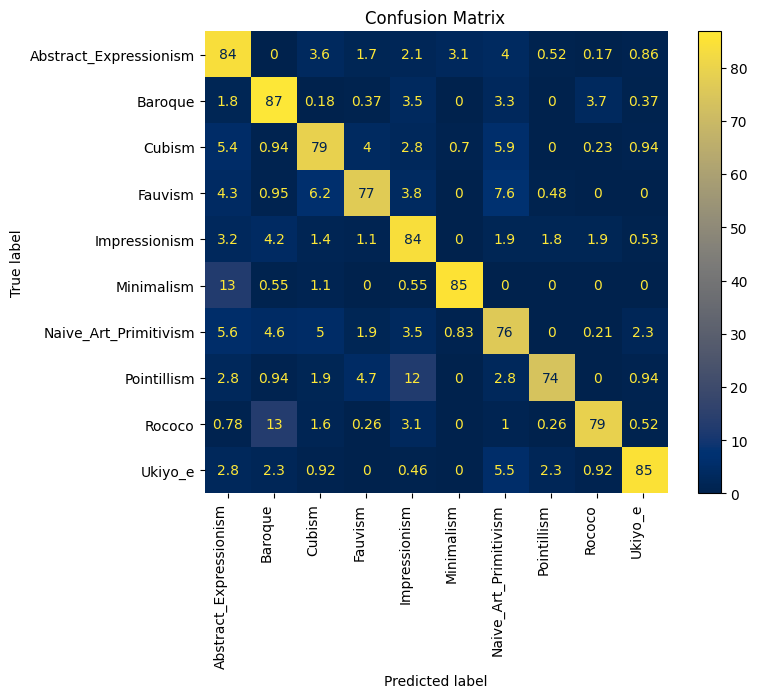

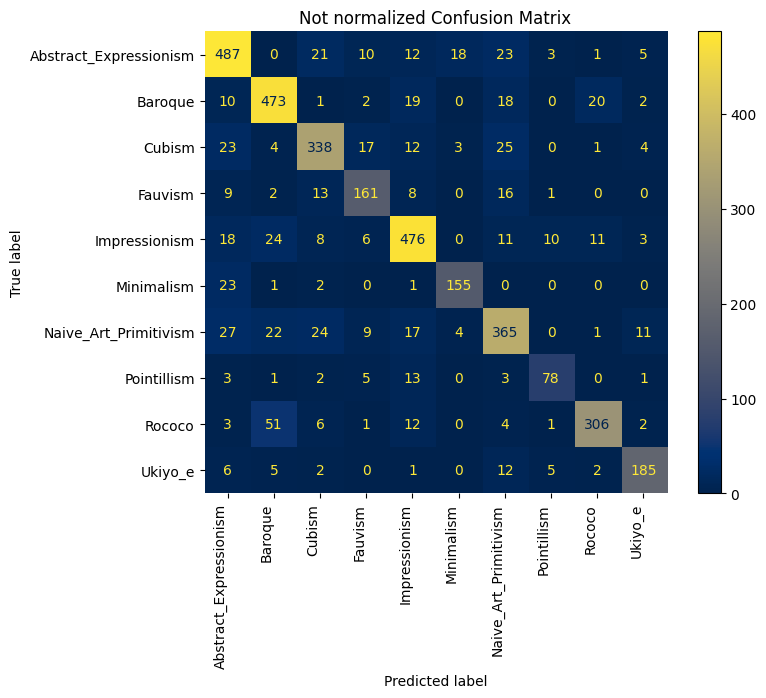

In [22]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(460, 140, 113),  
    solver='lbfgs',
    learning_rate_init=0.0003442691569297126,
    alpha= 5.2073160459223636e-06,  
    batch_size=32,  
    activation='relu',  
    max_iter=451,  
    random_state=42,
    early_stopping=True  
)

mlp_model.fit(X_train_scaled, y_train)
frmodel_pred = mlp_model.predict(X_test_scaled)
frmodel_pred_proba = mlp_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [23]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(460, 140, 113),  
    solver='lbfgs',
    learning_rate_init=0.0003442691569297126,
    alpha= 5.2073160459223636e-06,  
    batch_size=32,  
    activation='relu',  
    max_iter=451,  
    random_state=42,
    early_stopping=True  
)

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  mlp_model , 1)
print(avg)
print("....")

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.817419  0.817076  0.816968  0.817076   17.190378   
1         2   0.819292  0.819238  0.818793  0.819238   18.189701   
2         3   0.818572  0.818157  0.818024  0.818157   18.520890   
3         4   0.805911  0.806269  0.805774  0.806269   17.310912   
4         5   0.822067  0.821940  0.821827  0.821940   17.199286   
5   Average   0.816652  0.816536  0.816277  0.816536   17.682234   
6  1.581139   0.006244  0.006018  0.006143  0.006018    0.627277   

   Prediction time  
0         0.014321  
1         0.014101  
2         0.013989  
3         0.013944  
4         0.014024  
5         0.014076  
6         0.000149  
....


In [24]:
a = 0
a

0

/venv/main/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.812069  0.814879  0.813472   578.000000
Baroque                  0.869725  0.807496  0.837456   587.000000
Cubism                   0.822014  0.738947  0.778271   475.000000
Fauvism                  0.676190  0.876543  0.763441   162.000000
Impressionism            0.894180  0.739067  0.809258   686.000000
Minimalism               0.813187  0.913580  0.860465   162.000000
Naive_Art_Primitivism    0.756250  0.797802  0.776471   455.000000
Pointillism              0.698113  0.891566  0.783069    83.000000
Rococo                   0.753886  0.915094  0.826705   318.000000
Ukiyo_e                  0.793578  0.887179  0.837772   195.000000
accuracy                 0.808971  0.808971  0.808971     0.808971
macro avg                0.788919  0.838215  0.808638  3701.000000
weighted avg             0.816419  0.808971  0.809030  3701.000000
--------------------------------------------------------------

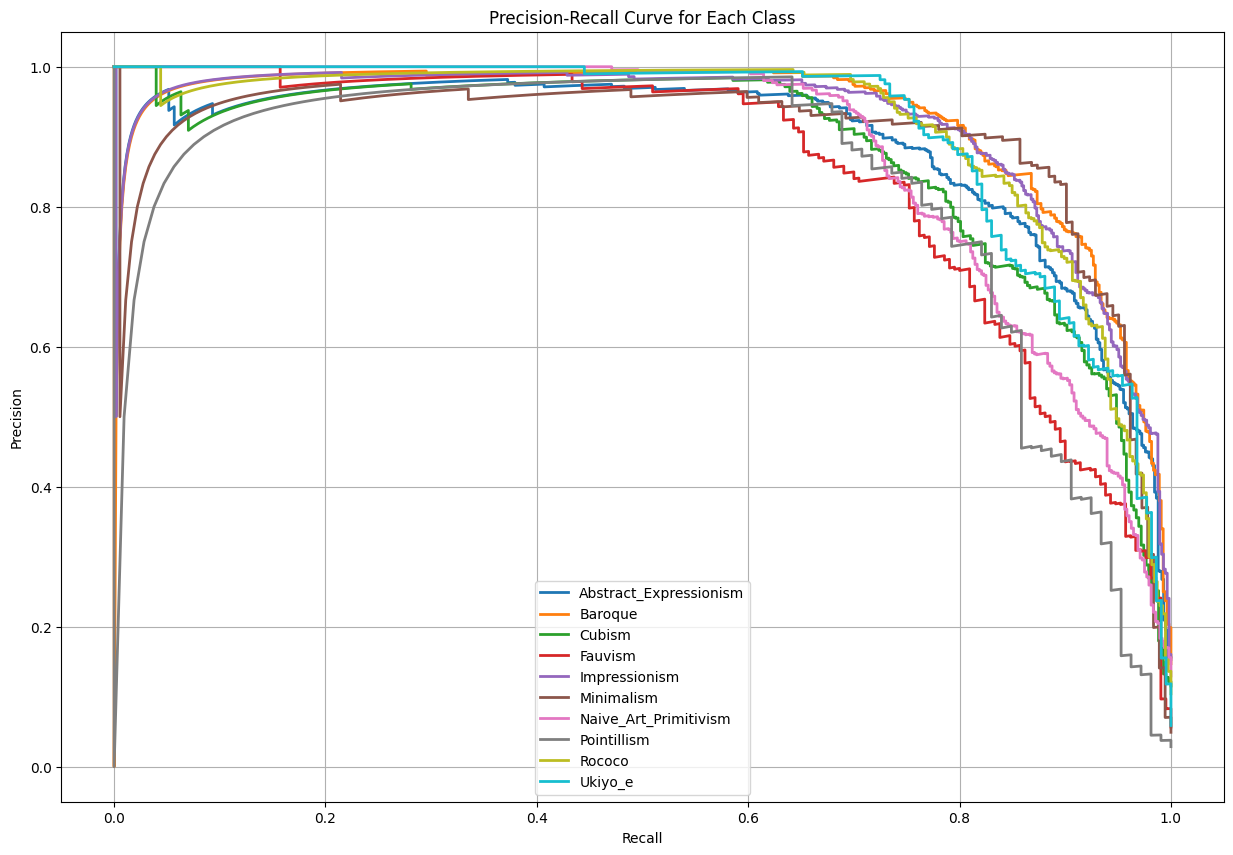

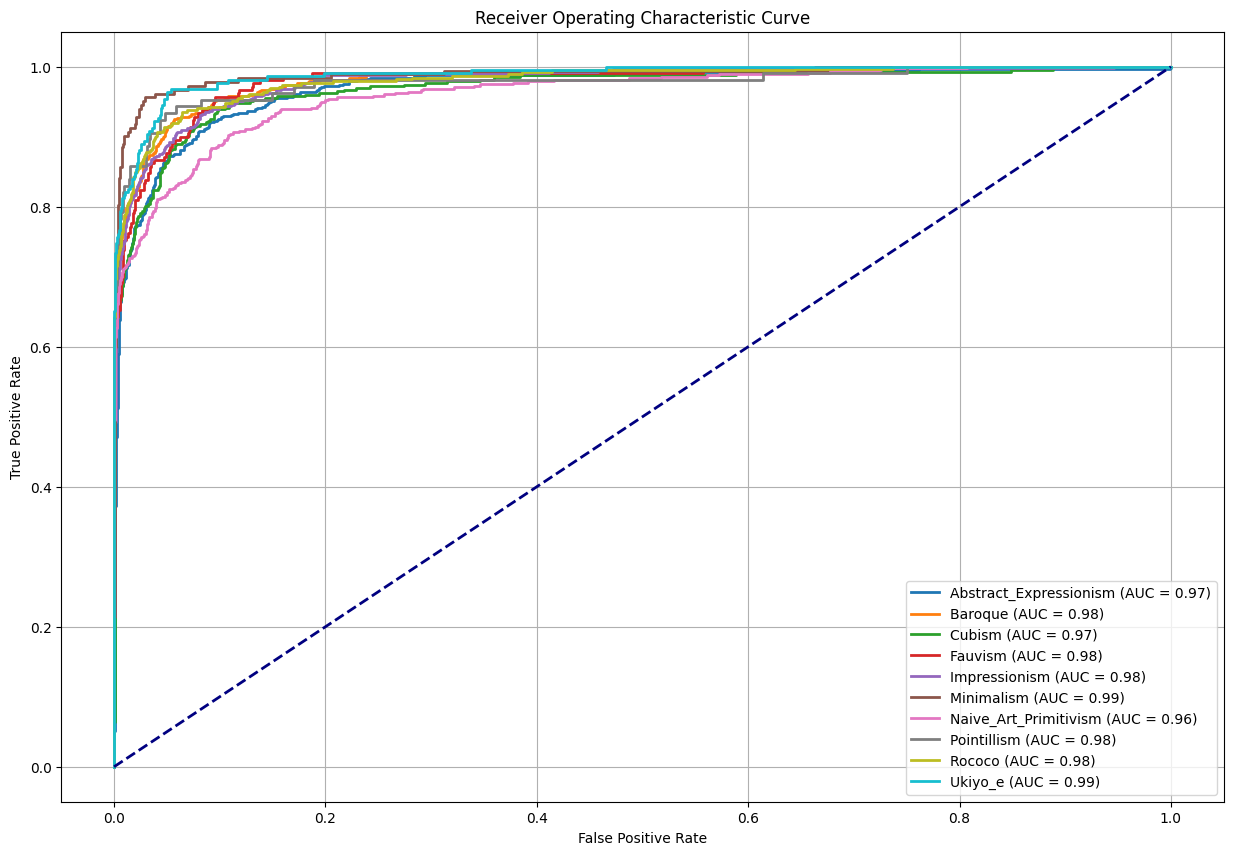

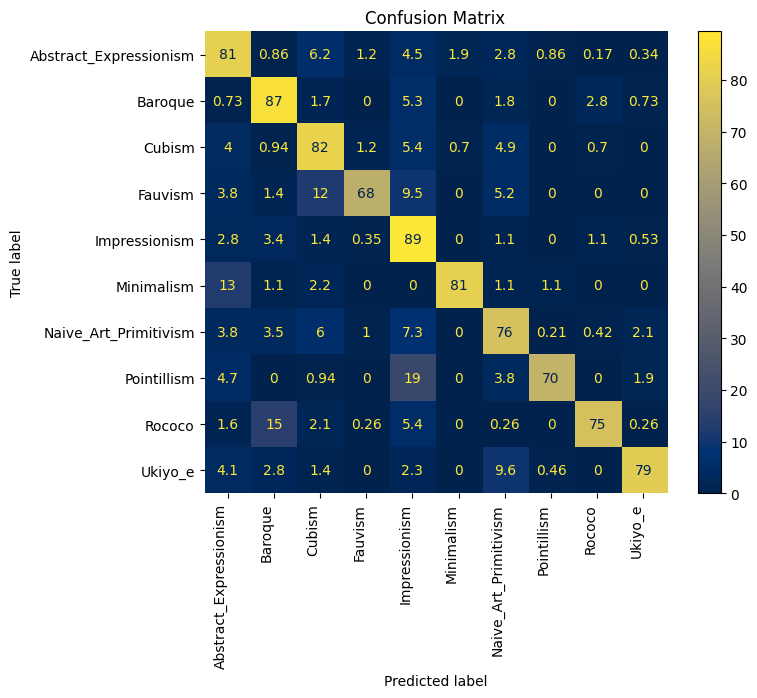

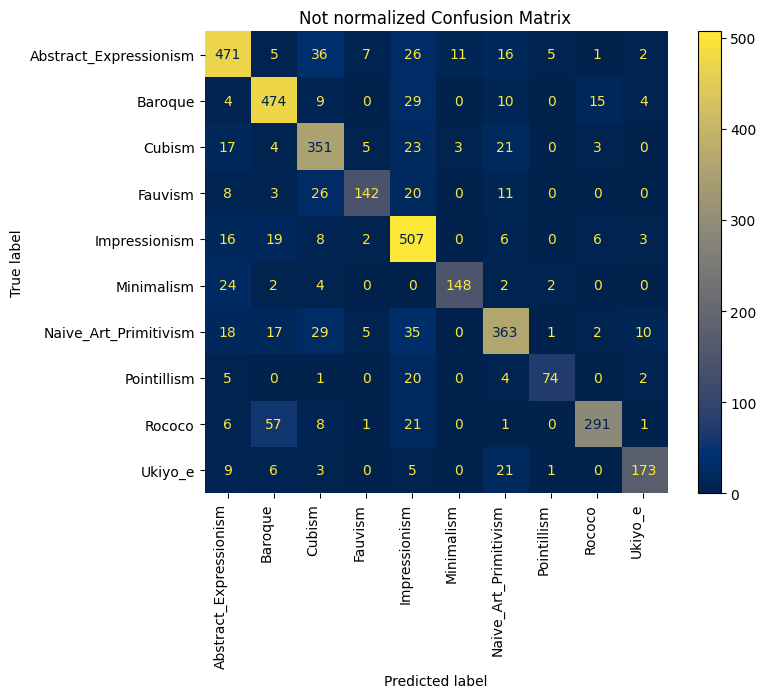

In [25]:
from sklearn.svm import SVC

svc_model = SVC(
    kernel='poly', 
    C=8.84138272579024, 
    gamma=7.4517282425369755, 
    degree=3, 
    random_state=42,
    probability = True
)

svc_model.fit(X_train_scaled, y_train)
frmodel_pred = svc_model.predict(X_test_scaled)
frmodel_pred_proba = svc_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [26]:
svc_model = SVC(
    kernel='poly', 
    C=8.84138272579024, 
    gamma=7.4517282425369755, 
    degree=3, 
    random_state=42,
    probability = True
)

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  svc_model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.828313  0.821670  0.821461  0.821670  217.492923   
1         2   0.827958  0.821940  0.821500  0.821940  218.033587   
2         3   0.823936  0.817076  0.816801  0.817076  220.576423   
3         4   0.820651  0.814915  0.814690  0.814915  218.127193   
4         5   0.830828  0.824372  0.823964  0.824372  232.620634   
5   Average   0.826337  0.819995  0.819683  0.819995  221.370152   
6  1.581139   0.004025  0.003875  0.003809  0.003875    6.400892   

   Prediction time  
0         9.230411  
1         9.558070  
2         9.272044  
3         9.155554  
4         9.657242  
5         9.374664  
6         0.219566  


In [2]:
!pip install opencv-python-headless
!pip install scikit-learn
!pip install matplotlib
! pip install imageio
!pip install torchsampler
!pip install xgboost
!pip install torchmetrics
!pip install pytorch_lightning
!pip install optuna
!pip install memory_profiler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 88.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 149.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 105.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 113.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 177.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 160.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 10.5 MB/s eta 0:00:00
   

In [8]:
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 107.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 66.0 MB/s eta 0:00:00
